In [1]:

import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

#NLTK stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cmckinni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Word Cloud

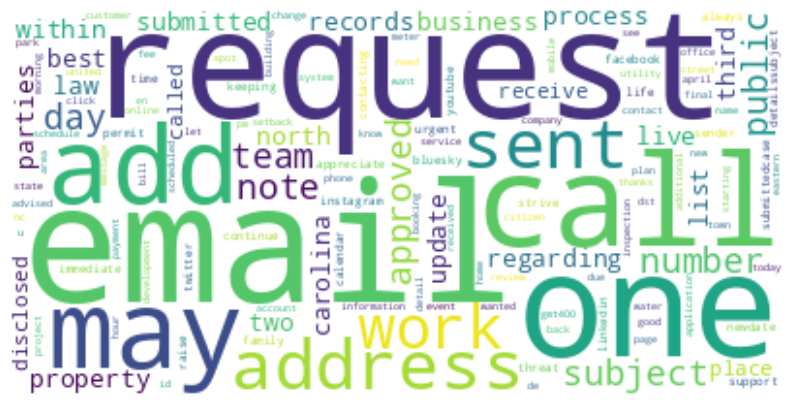

In [61]:
def create_dataframe(path='1_000_cases.csv'):
    df = pd.read_csv(path, parse_dates=['CreatedDate'])
    df['CreatedDate'] = df.CreatedDate.dt.tz_convert(None)
    df['CaseDate'] = df['CreatedDate'].dt.date
    return df

def filter_classification(df: pd.DataFrame, level='Category', selections=['all']):
    # Filters the Dataframe to include only those rows where 'level' is any of the 'selections' (or all)
    if not selections or 'all' in selections:
        return df
    else:
        return df[df[level].isin(selections)].reset_index(drop=True)
    
def filter_time(df: pd.DataFrame, start_date, end_date):
    # Filters the Dataframe to include only those rows where 'Date' is between 'start_date' and 'end_date'
    filtered = df[(df['CaseDate'] >= start_date) & (df['CaseDate'] <= end_date)]
    return filtered.reset_index(drop=True)

def remove_stop_junk_words (text, junk_words: list):
    STOPWORDS = set(stopwords.words('english')) | set(junk_words)
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return ' '.join(w for w in text.split() if w not in STOPWORDS)

def get_corpus(df: pd.DataFrame, field='Description', junk_words: list=[]):
    texts = df[field].dropna()
    return ' '.join(remove_stop_junk_words(t, junk_words) for t in texts)

def make_cloud(text, max_words=200, color_map='viridis', bg_color='white', mask=None):
    wc = WordCloud(
        max_words=max_words,
        colormap=color_map,
        background_color=bg_color,
        mask=mask,
        collocations=False
    ).generate(text)
    return wc

def display_cloud(wc:WordCloud):
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def run(df: pd.DataFrame):
    # pull unique options
    cats = sorted(df['Category'].dropna().unique())
    subcats = sorted(df['Subcategory'].dropna().unique())
    scens = sorted(df['Scenario'].dropna().unique())

    # widgets
    start_dp    = widgets.DatePicker(description='Start', value=df.CaseDate.min())
    end_dp      = widgets.DatePicker(description='End',   value=df.CaseDate.max())
    max_w       = widgets.IntSlider(description='Max words', min=50, max=500, value=200)
    cmap_dd     = widgets.Dropdown(description='Colormap', options=['viridis','plasma','magma','inferno'], value='viridis')
    bg_dd       = widgets.Dropdown(description='BG color', options=['white','black'], value='white')
    exclude_txt = widgets.Text(description='Exclude:', placeholder='spam, test, foo')
    gen_btn     = widgets.Button(description='Generate', button_style='success')

    cat_sel    = widgets.SelectMultiple(options=cats,    description='Category')
    subcat_sel = widgets.SelectMultiple(options=subcats, description='Subcategory')
    scen_sel   = widgets.SelectMultiple(options=scens,   description='Scenario')

    # layout
    controls = widgets.VBox([
        widgets.HBox([start_dp, end_dp]),
        widgets.HBox([cat_sel, subcat_sel, scen_sel]),
        widgets.HBox([max_w, cmap_dd, bg_dd]),
        exclude_txt,
        gen_btn
    ])

    # callback
    def on_generate(_btn):
        clear_output(wait=True)
        display(controls)

        # read widget values
        start_date = start_dp.value
        end_date   = end_dp.value
        max_words  = max_w.value
        colormap   = cmap_dd.value
        bg_color   = bg_dd.value
        junk_words = [w.strip() for w in exclude_txt.value.split(',') if w.strip()]

        # filtering
        df_filtered = filter_classification(df, 'Category',    cat_sel.value)
        df_filtered = filter_classification(df_filtered, 'Subcategory', subcat_sel.value)
        df_filtered = filter_classification(df_filtered, 'Scenario',    scen_sel.value)
        df_filtered = filter_time(df_filtered, start_date, end_date)

        if df_filtered.empty:
            # show a friendly message instead of crashing
            display(widgets.HTML(
                "<b>No rows match those filters.</b><br>"
                "Try loosening your Category/Subcategory/Scenario or date range."
            ))
            return
    
        # generate & display
        corpus = get_corpus(df_filtered, junk_words=junk_words)
        wc = make_cloud(corpus, max_words=max_words, color_map=colormap, bg_color=bg_color)
        display_cloud(wc)

    # wire up
    gen_btn.on_click(on_generate)

    # initial display
    display(controls)

df = create_dataframe('data/1_000_cases.csv')
if df.empty:
    print("DataFrame is empty. Please check the CSV file path and content.")
run(df)